# Membership inference attack with images
## Target a CNN
Authors : Johan Jublanc

We use this article to simulate a membership inference attack : https://arxiv.org/pdf/1807.09173.pdf

### Imports

In [31]:
import numpy as np
import pandas as pd
from sklearn import datasets

from os import listdir
from os.path import isfile, join

import urllib.request

import tarfile

from sklearn import metrics
import xgboost as xgb

from scipy.ndimage import rotate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

In [32]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [34]:
# tf.__version__ == 2.x
tf.__version__

'2.2.0'

## Get the data from cifar10

We use the CIFAR10 data which is a dataset of color images of size 32x32. For more information let's go here :
- https://www.cs.toronto.edu/~kriz/cifar.html

The process can take a while ;)

In [35]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# urllib.request.urlretrieve(url, data_file_name)

In [36]:
import pathlib
data_dir = tf.keras.utils.get_file(origin=url, fname='cifar10', untar=True)

In [37]:
root_keras_data_path = "/".join(data_dir.split("/")[:5])
cifar_data_path = os.path.join(root_keras_data_path, "cifar-10-batches-py")
os.listdir(cifar_data_path)

['data_batch_1',
 'readme.html',
 'batches.meta',
 'data_batch_2',
 'data_batch_5',
 'test_batch',
 'data_batch_4',
 'data_batch_3']

In [38]:
data_batches_names = []
for item in os.listdir(cifar_data_path):
    if item.startswith("data_batch"):
        data_batches_names.append(item)

CIFAR10 data are splited in batches. For this example the first batche is used to build up a classifier and the second one will be used to build up the attack.

In [39]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [40]:
data = []
for data_batches_name in data_batches_names:
    data.append(unpickle(os.path.join(cifar_data_path, data_batches_name)))
    print(data_batches_name)

data_batch_1
data_batch_2
data_batch_5
data_batch_4
data_batch_3


__Split data__

We firstly build a model that is trained on the dataset $data_b$, the dataset $data_a$ is used to evaluate the attack.

In [41]:
from sklearn.model_selection import train_test_split
x_a = data[0][b"data"]
y_a = data[0][b"labels"]
x_a1, x_a2, y_a1, y_a2 = train_test_split(x_a, y_a, test_size=.2)

x_b = data[1][b"data"]
y_b = data[1][b"labels"]
x_b1, x_b2, y_b1, y_b2 = train_test_split(x_b, y_b, test_size=.2)

__Get a shadow dataset__

Here the attacker knows another dataset that is similar to D. Here we use batch 2.

In [42]:
x_prim_in = data[2][b"data"]
y_prim_in = data[2][b"labels"]
print(os.path.join(cifar_data_path, data_batches_names[0]))

x_prim_in_train, \
x_prim_in_test, \
y_prim_in_train, \
y_prim_in_test = train_test_split(x_prim_in,
                                  y_prim_in,
                                  test_size=.2)

/Users/johanjublanc/.keras/datasets/cifar-10-batches-py/data_batch_1


__Batch 3 is used to get intput out of scope used to train the shadow model__

In [43]:
x_prim_out = data[3][b'data']
y_prim_out = data[3][b'labels']

x_prim_out_train, \
x_prim_out_test, \
y_prim_out_train, \
y_prim_out_test = train_test_split(x_prim_out,
                                   y_prim_out,
                                   test_size=.2)

__Define training parameters__

In [44]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
SHUFFLE_SIZE = 200
NUM_EPOCHS = 1

In [45]:
input_shape = (32, 32, 3)
num_classes = 10
len_train = 8000

## Function constituting the whole pipeline :
* reshape images
* create a MapDataset
* plt example images
* create a target
* load and save trained models

In [46]:
def reshape_images(flat_array):
    flat_array_normalized = tf.cast(flat_array, tf.float32) / 255.
    img_reshaped = tf.reshape(flat_array_normalized, (3, 32, 32))
    return tf.transpose(img_reshaped)

We define a function to create a dataset tensorflow

In [47]:
def input_fn(flat_arrays, labels, 
             BATCH_SIZE = BATCH_SIZE, 
             SHUFFLE_SIZE = SHUFFLE_SIZE, 
             NUM_EPOCHS = NUM_EPOCHS):
    ds_x = tf.data.Dataset.from_tensor_slices(flat_arrays)
    ds_x = ds_x.map(reshape_images)
    ds_y = tf.data.Dataset.from_tensor_slices(labels)
    ds_x_y = tf.data\
               .Dataset\
               .zip((ds_x, ds_y))\
               .shuffle(SHUFFLE_SIZE)\
               .repeat(NUM_EPOCHS)\
               .batch(BATCH_SIZE)\
               .prefetch(1)
    return ds_x_y

In [48]:
def plt_img_labels(img_batch, label_batch):
    plt.figure(figsize=(10,10))

    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = rotate(img_batch[n], -90)
        plt.imshow(img)
        plt.title(str(label_batch[n].numpy()))
        plt.axis('off')

A first model is trained on 80% of the $data_b$ and test on the 20% left
We use this article to build a quite good model : https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [49]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,
                  metrics=['sparse_categorical_accuracy'])
    return model

__Load/Save model__

In [50]:
if "models" not in os.listdir():
    os.mkdir("models")

In [51]:
import glob
def return_model_num(pattern):
    target_models_list = glob.glob(pattern)
    num_list = [x.split("/")[1].split(".")[0].split("_")[1] for x in target_models_list]
    num_list_int = [int(x) for x in num_list]
    return np.max(num_list_int)

In [52]:
def save_new_model(pattern, model):
    if len(glob.glob(pattern))==0:
        model.save(pattern.split("_")[0] + "_0.h5")
    else:
        num = return_model_num(pattern) + 1
        model.save(pattern.replace("*", str(num)))

In [53]:
def get_model(pattern, input_shape):
    if len(glob.glob(pattern))==0:
        model = create_model(input_shape)
    else:
        num = return_model_num(pattern)
        filepath = pattern.replace("*", str(num))
        model = tf.keras.models.load_model(filepath)
        print(filepath)
    return model

## Train target model

__Create dataset objects__

In [54]:
ds_xy_b1 = input_fn(x_b1, y_b1)
ds_xy_b2 = input_fn(x_b2, y_b2)

__Plot some example__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


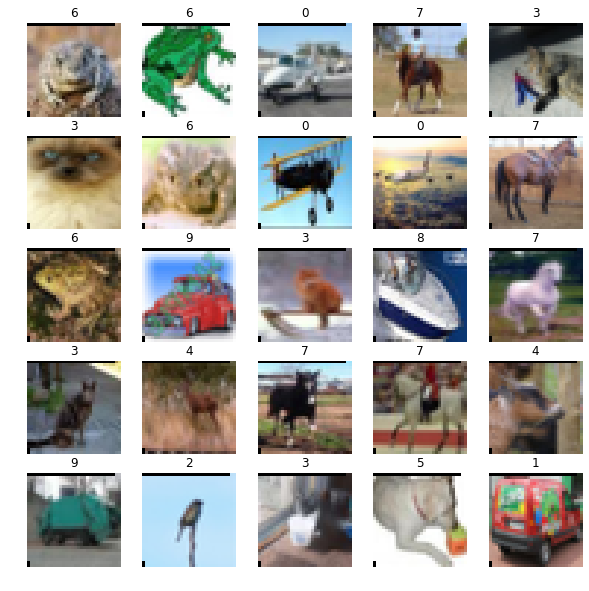

In [55]:
len_train = len(y_b1)
img_batch, label_batch = next(iter(ds_xy_b1))
plt_img_labels(img_batch, label_batch)

__Load pretrained or create a new model__

In [56]:
pattern = 'models/target_*.h5'
target_model = get_model(pattern, input_shape)

models/target_0.h5


In [57]:
history = target_model.fit(ds_xy_b1,
            epochs=NUM_EPOCHS,
            steps_per_epoch=len_train//BATCH_SIZE,
            verbose=1,
            validation_data=(ds_xy_b2))
score = target_model.evaluate(ds_xy_b2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 23s 93ms/step - loss: 2.2501 - sparse_categorical_accuracy: 0.1936 - val_loss: 2.2473 - val_sparse_categorical_accuracy: 0.1950
Test loss: 2.2473320960998535
Test accuracy: 0.19499999284744263


__Save the model__

In [58]:
save_new_model(pattern, target_model)

In [59]:
pattern = 'models/target_*.h5'
target_model = get_model(pattern, input_shape)
target_model.summary()

models/target_1.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8

## Train the shadow model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


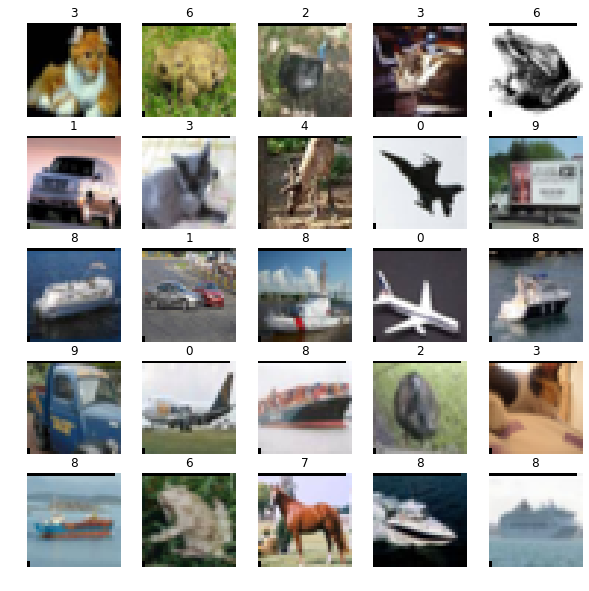

In [60]:
ds_prim_in_train = input_fn(x_prim_in_train, y_prim_in_train)
ds_prim_in_test = input_fn(x_prim_in_test, y_prim_in_test)

img_batch, label_batch = next(iter(ds_prim_in_train))
plt_img_labels(img_batch, label_batch)

In [61]:
pattern = 'models/prim_*.h5'
model_shadow = get_model(pattern,input_shape)

models/prim_0.h5


In [62]:
history_shadow = model_shadow.fit(ds_prim_in_train,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=len_train//BATCH_SIZE,
                              verbose=1,
                              validation_data=(ds_prim_in_test))
score = model_shadow.evaluate(ds_prim_in_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 24s 96ms/step - loss: 2.2798 - sparse_categorical_accuracy: 0.1469 - val_loss: 2.2672 - val_sparse_categorical_accuracy: 0.1480
Test loss: 2.267202615737915
Test accuracy: 0.14800000190734863


In [63]:
save_new_model(pattern, model_shadow)

## Build up the attack

__Build a dataset $D^*$ to train the attack__

Now that we have trained our model on the "in" part of the data, we can make a prediction on both dataset's parts ("in" and "out") a labelise the results. The new dataset is named $D*$

In [64]:
def input_fn_pred(x):
    ds_x = tf.data.Dataset.from_tensor_slices(x)\
                                  .map(reshape_images)\
                                  .batch(x.shape[0])
    return ds_x

In [65]:
ds_x_prim_in = input_fn_pred(x_prim_in_train)
ds_x_prim_out = input_fn_pred(x_prim_out_train)

In [66]:
x_star_in = model_shadow.predict(ds_x_prim_in)
y_star_in = [1 for i in range(len(x_star_in))]

x_star_out = model_shadow.predict(ds_x_prim_out)
y_star_out = [0 for i in range(len(x_star_out))]

In [67]:
x_star = np.concatenate([x_star_in, x_star_out], axis=0)
y_star = np.concatenate([y_star_in, y_star_out], axis=0)

In [68]:
len(x_star)

16000

In [69]:
x_star_train, \
x_star_test, \
y_star_train, \
y_star_test = train_test_split(x_star, y_star, test_size =.2)

__Create XGBOOST attack model__

ref : https://www.datacamp.com/community/tutorials/xgboost-in-python#apply

In [70]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.8,
                                learning_rate = 0.01,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 20)

clf_attack.fit(x_star_train, y_star_train)
print("Accuracy:", metrics.accuracy_score(y_star_test, clf_attack.predict(x_star_test)))

Accuracy: 0.5009375


In [71]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.3,
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 10)
clf_attack.fit(x_star,y_star)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

__Create NN attack model__

In [72]:
from tensorflow.keras.models import Sequential

In [73]:
SHUFFLE_SIZE = 1000
NUM_EPOCHS = 10
BATCH_SIZE = 80

In [74]:
ds_star_train_x = tf.data.Dataset.from_tensor_slices(x_star_train)
ds_star_train_y = tf.data.Dataset.from_tensor_slices(y_star_train)
ds_star_train_xy = tf.data.Dataset\
                          .zip((ds_star_train_x, ds_star_train_y))\
                          .shuffle(SHUFFLE_SIZE)\
                          .repeat(NUM_EPOCHS)\
                          .batch(BATCH_SIZE)

In [75]:
ds_star_test_x = tf.data.Dataset.from_tensor_slices(x_star_test)
ds_star_test_y = tf.data.Dataset.from_tensor_slices(y_star_test)
ds_star_test_xy = tf.data.Dataset\
                          .zip((ds_star_test_x, ds_star_test_y))\
                          .shuffle(SHUFFLE_SIZE)\
                          .repeat(NUM_EPOCHS)\
                          .batch(BATCH_SIZE)

In [76]:
NN_attack = Sequential()
NN_attack.add(Dense(50, activation='relu', input_shape = (10,)))
NN_attack.add(Dense(1, activation='softmax'))

In [77]:
opt = SGD(lr=0.001, momentum=0.9)
NN_attack.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=opt,
                  metrics=['accuracy'])

In [78]:
history_attack = NN_attack.fit(ds_star_train_xy,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=8000//BATCH_SIZE,
                               validation_data=ds_star_test_xy
                               )

Epoch 1/10
100/100 [==============================] - 1s 6ms/step - loss: 0.8126 - accuracy: 0.5006 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 2/10
100/100 [==============================] - 0s 5ms/step - loss: 0.8121 - accuracy: 0.5011 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 3/10
100/100 [==============================] - 1s 5ms/step - loss: 0.8126 - accuracy: 0.5006 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.8165 - accuracy: 0.4967 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 5/10
100/100 [==============================] - 1s 5ms/step - loss: 0.8100 - accuracy: 0.5033 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 6/10
100/100 [==============================] - 1s 5ms/step - loss: 0.8131 - accuracy: 0.5001 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 7/10
100/100 [==============================] - 1s 5ms/step - loss: 0.8173 - accuracy: 0.4960 - val_loss: 0.8136 - val_accuracy: 0.4997
Epoch 

# Test the attack against the true data set D

In [79]:
def get_predictions_and_labels(target_model, attack_model, data, label):
    
    ds_data = input_fn_pred(data)
    
    # Information we have thanks to the API (original model)
    probas   = target_model.predict(ds_data)

    # Model we have trained to make the attack
    prediction = clf_attack.predict(probas)

    # Results zipping prediction an true labels
    result  = pd.DataFrame(zip(prediction, [label for i in range(len(probas))]), 
                           columns = ("y_pred", "y"))
    
    return result

Results for images out of the training dataset

In [80]:
results_a = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=NN_attack, 
                                       data=x_a1, label=0)

Results for images in the training dataset

In [81]:
results_b = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=NN_attack,
                                       data=x_b1, label=1)

Measure the accuracy of the attack

In [82]:
attack_results = pd.concat([results_a, results_b]).reset_index().drop("index", axis=1)

In [83]:
print("Accuracy:", metrics.accuracy_score(attack_results["y"], attack_results["y_pred"]))

Accuracy: 0.4989375
